# Tarea 9

_Tarea 9_ de _Benjamín Rivera_
para el curso de __Métodos Numéricos__
impartido por _Joaquín Peña Acevedo_.
Fecha limite de entrega __...__.

In [1]:
import sys
import seaborn as sns
import scipy

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular # Para backward y forward substitution

NOTEBOOK = True

## Ejercicio 1.

Escriba un programa que interpole un conjunto de puntos $\{(x_0 , f_0 ), ..., (x_n , f_n )\}$ mediante un spline natural cúbico.

### Parte 1

Escriba una función que reciba como argumentos:
 - Un apuntador a un arreglo 2D de tamaño (n + 1) × 2 en el que cada fila tiene las coordenadas $(x_i , f_i)$ de un punto en el plano.
 - el entero $n$,

La función debe resolver el sistema triadiagonal que permite calcular los valores $M_0 , M_1 , ..., M_n$ de las segundas derivadas del spline en los nodos $x_0 < x_1 < ... < x_n$ ,
y para que el spline sea “natural” se debe tener que $M_0 = M_n = 0$.
La función debe devolver un arreglo con los valores $M_0 , M_1 , ..., M_n$.

In [2]:
def una_funcion( arreglo, n, dtype=np.float64):
    
    # Extraccion de vectores del arreglo
    xs = arreglo[0]
    fxs = arreglo[1]
    
    # inicializacion de vectores
    hs = np.zeros(n-1)
    bs = np.zeros(n-1)
    
    us = np.zeros(n-1)
    ds = np.zeros(n-1)
    
    Ms = np.zeros(n)
    
    lim = n-1
    
    for i in range(lim):
        hs[i] = xs[i+1] - xs[i]
        bs[i] = 6*(fxs[i+1] - fxs[i])/hs[i]
    
    us[1] = 2*(hs[0] + hs[1])
    ds[1] = bs[1] - bs[0]
    for i in range(2, lim):
        us[i] = 2*(hs[i] + hs[i-1]) - hs[i-1]**2/us[i-1]
    
    # Calculo de coeficientes
    Ms[-1] = 0
    for i in range(n-2, 0, -1):
        Ms[i] = (ds[i] - hs[i]*Ms[i+1])/us[i]      
    Ms[0] = 0
    
    return Ms

### Parte 2

Escriba una función para evaluar el spline cúbico en un punto $x$. Debe recibir 
 - el apuntador a la matriz que tiene los $n + 1$ puntos $(x_i , f_i )$, 
 - el arreglo que tiene los valores de los coeficientes $M_0 , M_1 , ..., M_n$ del spline natural, 
 - el entero $n$ y 
 - un valor $x ∈ [x_0 , x_n ]$. 

La función debe determinar el subintervalo $[x_{i−1} , x_i ]$ que contiene el punto $x$ y que devuelve el valor del polinomio cúbico

$$ S_{i-1}(x) = M_{i-1}\frac{(x_i - x)^3}{6*h_i} + M_i\frac{(x - x_{i-1})^3}{6h_i} + C_{i-1}(x - x_{i-1}) + C_{i-1} $$

donde

$$ h_i = x_i - x_{i-1}, \quad C_{i-1} = f_{i-1} - M_{i-1}\frac{h_i^2}{6}, \quad C_{i-1} = \frac{f_i - f_{i-1}}{h_i} - \frac{h_i}{6} (M_i - M_{i-1})$$


In [3]:
def polinomio(arreglo, Ms, n, x):
    """ Polinomio para evaluar. """
    xs = arreglo[0]
    fs = arreglo[1]
    

    def h(i):
        """ Parte h del polinomio a evaluar. """
        nonlocal xs
        return xs[i] - xs[i-1]

    def Cg(im1):
        """ Parte C gorro del polinomio a evaluar. 
        
        Se calculara el valor de i-1 en funcion del i dado.
        """
        nonlocal Ms, fs, xs
        i = im1
        return fs[i] - Ms[i]*h(i+1)**2/6

    def C(im1):
        """ Parte C del polinomio a evaluar. 
        
        Se calculara el valor de i-1 en funcion del i dado.
        """
        nonlocal Ms, fs, xs
        i = im1
        return (fs[i+1] - fs[i])/h(i+1) - (Ms[i+1] - Ms[i])*h(i+1)/6
    
    # Identificacion del intervalo
    i = 1
    while i <= len(xs):
        if xs[i-1] <= x <= xs[i]:
            break
        i += 1
    
    # evaluacion del polinomio
    try:
        return Ms[i-1]*(xs[i] - x)**3/(6*h(i)) + Ms[i]*(x - xs[i-1])**3/(6*h(i)) + C(i-1)*(x - xs[i-1]) + Cg(i-1)
    except:
        return 0


### Parte 3

Escriba el programa que recibe desde la lı́nea de comandos 
 - un entero $n$, y 
 - los valores $a$ y $b$; 
que corresponden a los extremos del intervalo $[a, b]$ y $n$ es el número de divisiones que se harán de ese intervalo.

El programa debe generar una partición del intervalo $[a, b]$, $a = x_0 < x_1 < ... < x_n = b$, y evaluar la función $f(x) = x + (1 + x) \sin(x^2) + 2 cos(6x)$ en esos puntos. Cree una matriz de tamaño $(n + 1) \times 2$ que tenga en cada fila los puntos $(x_i , f_i)$.

Use las funciones anteriores para obtener los coeficientes del spline natural $s(x)$ que interpola al conjunto de puntos.

Defina $m = 100$ y genere una partición uniforme del intervalo $[a, b]$ con $m+1$ puntos: $a = z_0 < z_1 < ... < z_m = b$. Evalue el spline en los puntos $z_0 , z_1 , ..., z_m$. Genere un archivo de texto que tenga tres columnas, de modo que cada fila del archivo tenga los siguientes datos:
$$ z_i \quad f(z_i) \quad s(z_i) $$

In [4]:
def fun(x):
    return x + (1+x)*np.sin(x**2) + 2*np.cos(6*x)

In [5]:
def parte3(n, a, b):
    f = np.vectorize(fun)
    # Para guardar en formato npy en local
    ext = ".npy" 
    file_name = "datos"
    path = "./"
    file_path = path+file_name+ext
    
    # particion
    xs = np.linspace(a, b, num=n+1, retstep=True)[0]
    fs = f(xs)
    
    # matriz
    mat = np.array([xs, fs])
    
    # valores y funciones
    Ms = una_funcion( mat, n+1)
    S = np.vectorize(lambda x: polinomio(mat, Ms, n+1, x))
    
    # Nuevas evaluaciones
    m = 100
    xs = np.linspace(a, b, num=m+1, retstep=True)[0]
    fs = f(xs)
    ss = S(xs)
    
    # Guardar datos
    with open(file_path, 'wb') as fil:
        # Guardar z_i, f(z_i). s(z_i)
        np.save(fil, np.array([xs, fs, ss]))

### Parte 4 

Pruebe el programa con $a = −3, b = 3, n = 10$ y con $n = 30$. Usando los archivos de salida, genere las gráficas que muestre la comporación de la gráfica de $f(x)$ y la del spline natural cúbico $s(x)$.

In [6]:
def tarea9(n, a, b):
    ext = ".npy" 
    file_name = "datos"
    path = "./"
    file_path = path + file_name + ext
    
    parte3(n, a, b)
    xs, fs, ss = np.load(file_path)
    
    plt.plot(xs, fs, '--', color='grey')
    plt.plot(xs, ss, '--', color='blue')

    plt.grid(axis='x', color='0.95')
    plt.show()

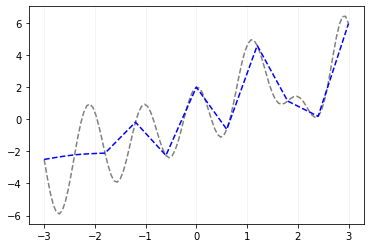

In [7]:
tarea9(10, -3, 3)

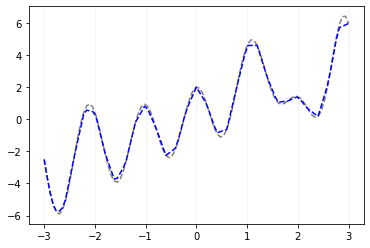

In [8]:
tarea9(30, -3, 3)